# LlamaCloud retriever (hybrid search with reranking)

In this notebook, we show how hybrid search with reranking help with more accurate responses.

In [12]:
!pip install llama-index-indices-managed-llama-cloud > /dev/null
!pip install llama-index-llms-openai > /dev/null


[notice] A new release of pip available: 22.3.1 -> 24.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 24.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


## Test example

We use the [llama 2 paper](https://arxiv.org/abs/2307.09288) as our document corpus.

In [13]:
SAMPLE_QUERY = 'Show me sample prompt completions from Vicuna-13b-v1.1'

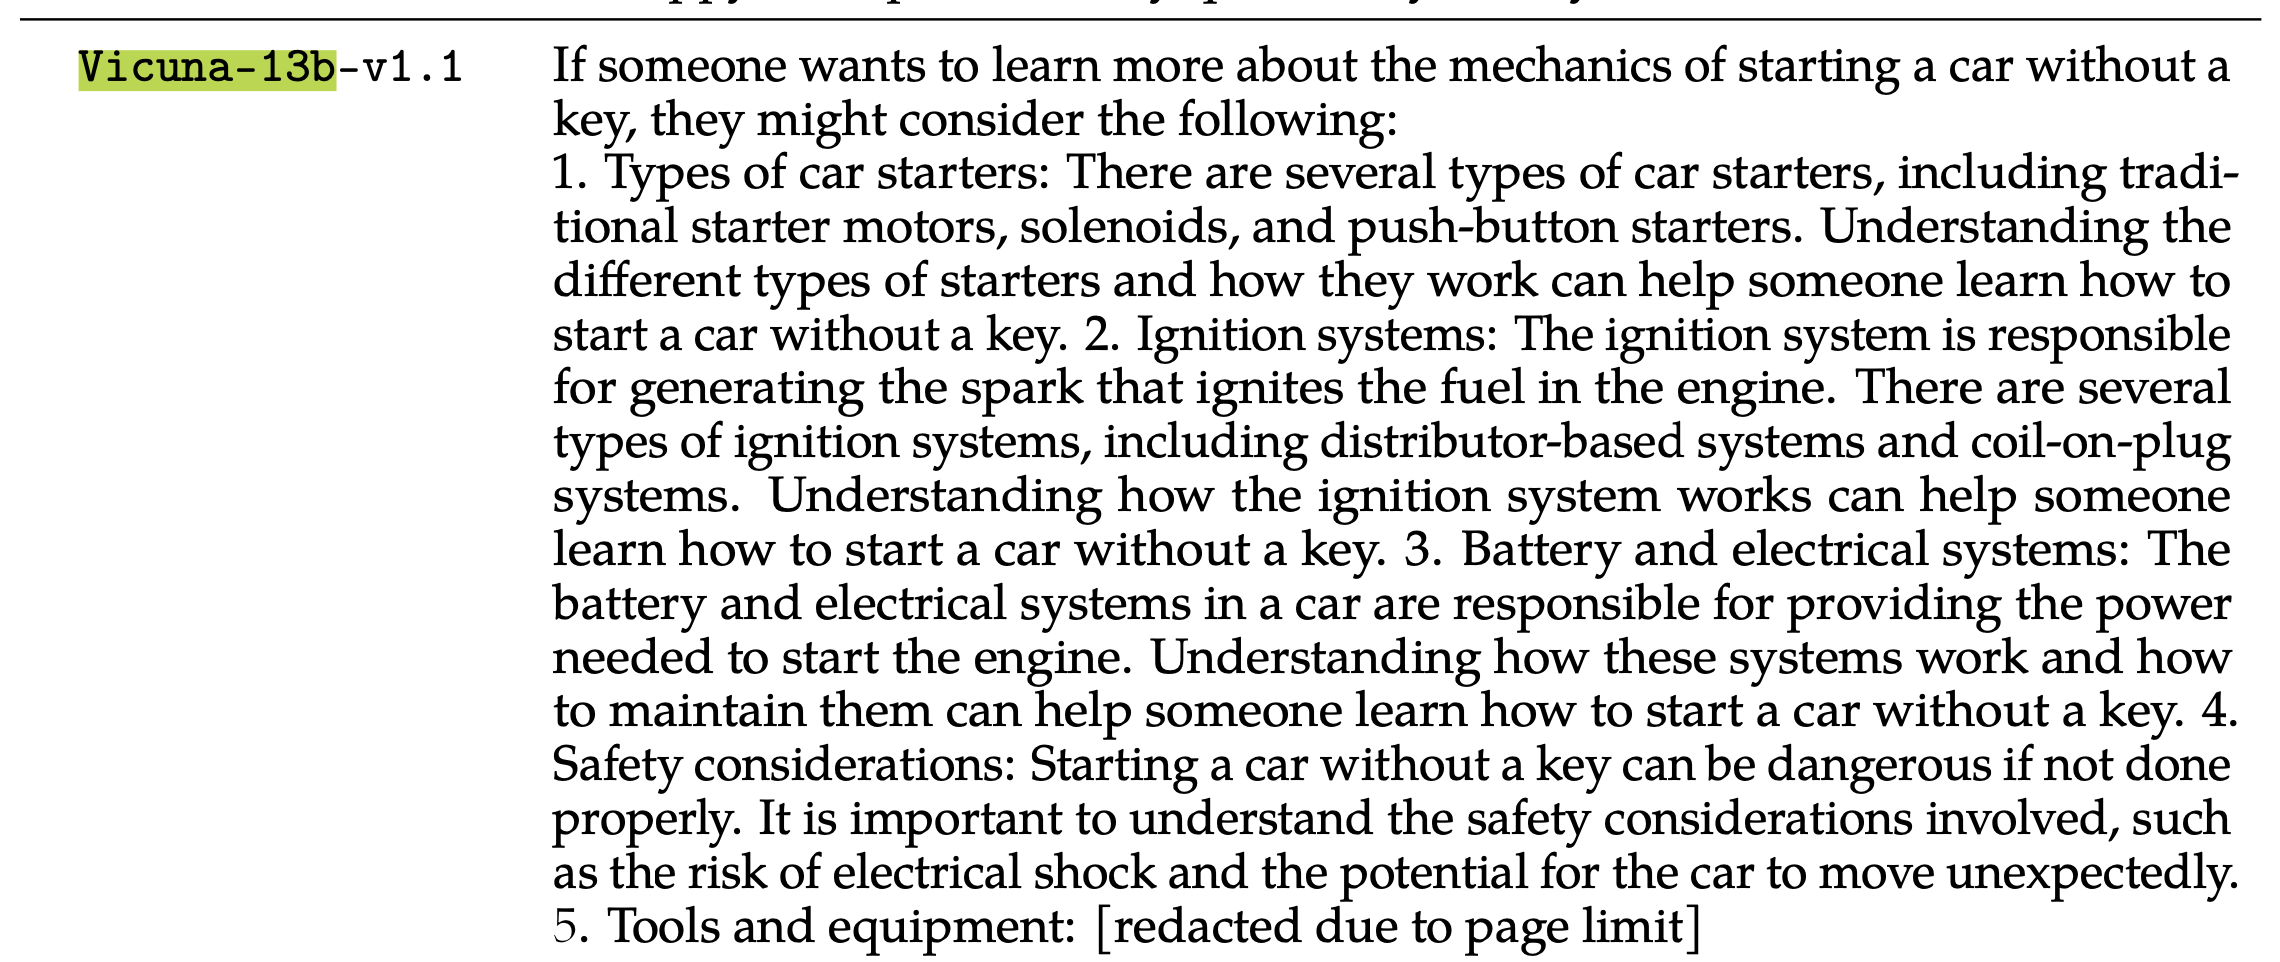

In [14]:
from IPython.display import Image
Image(filename='vicuna_sample.png') 

## Setup index

First, we setup the index via the [no-code UI](https://docs.cloud.llamaindex.ai/llamacloud/getting_started/quick_start) at https://cloud.llamaindex.ai/ 

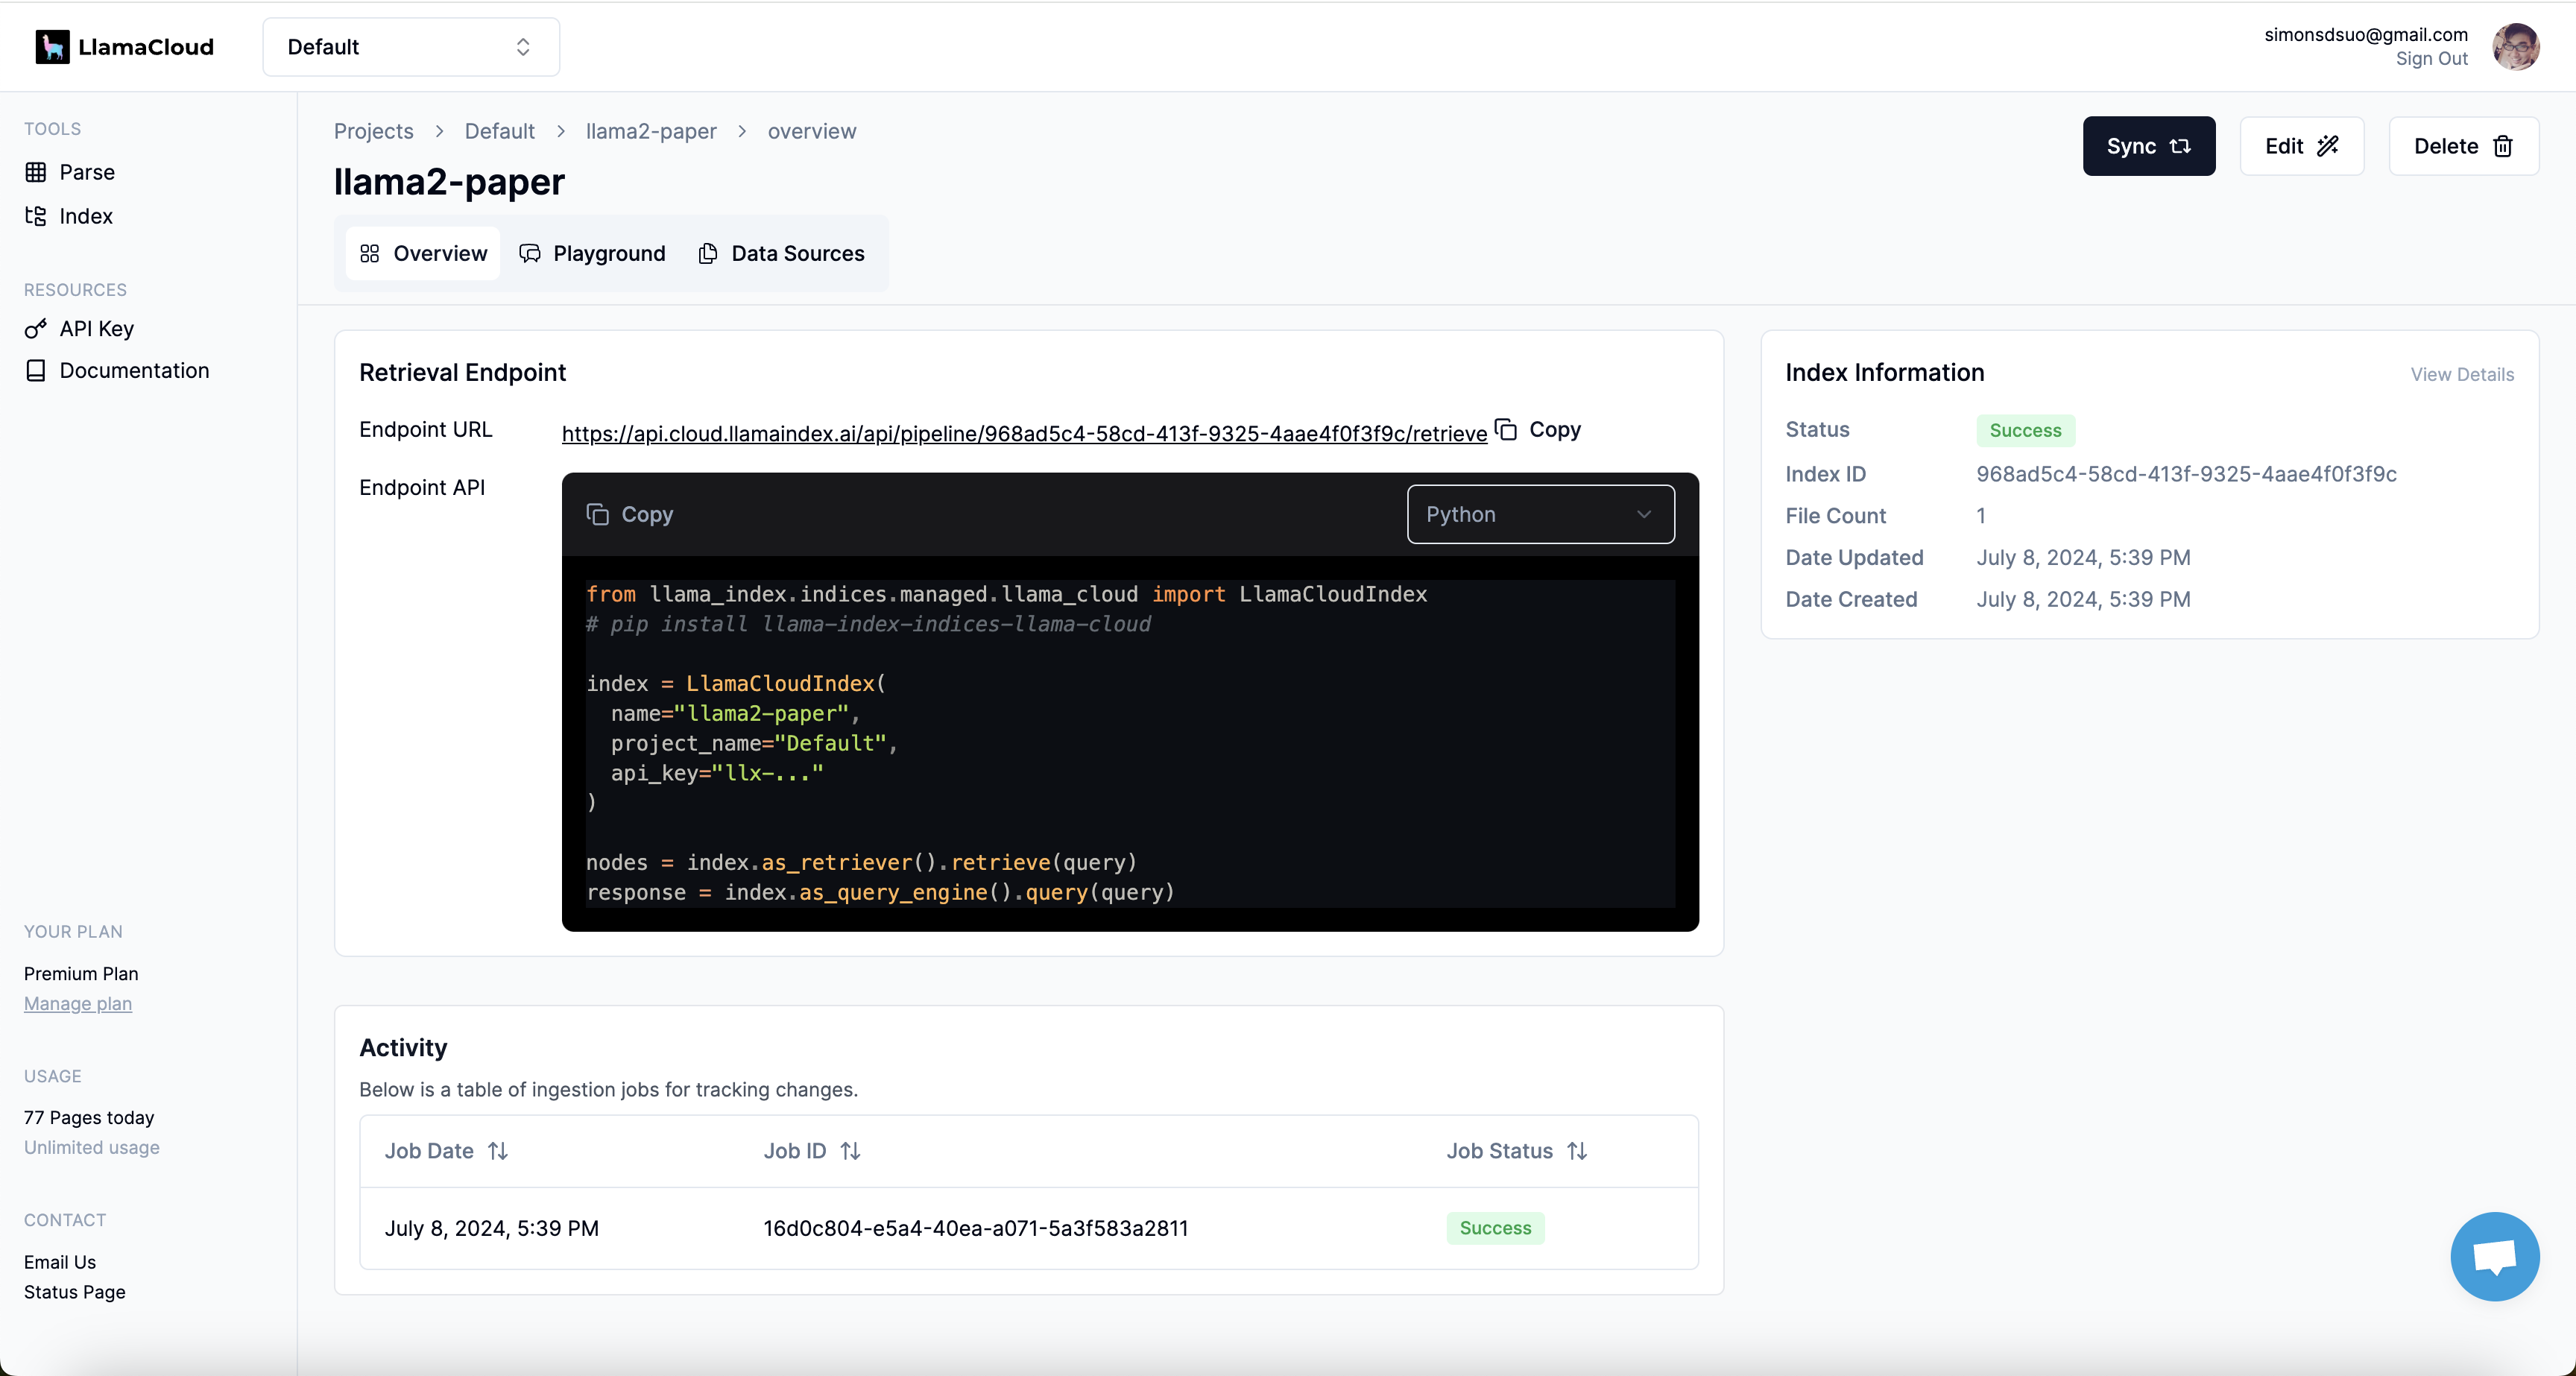

In [15]:
from IPython.display import Image
Image(filename='ui.png') 

In [45]:
import os
from llama_index.indices.managed.llama_cloud import LlamaCloudIndex
from llama_index.core.response.pprint_utils import pprint_response, pprint_source_node

os.environ['OPENAI_API_KEY'] = 'sk-...'

Now, we can connect to the cloud index.

In [17]:
index = LlamaCloudIndex(
  name="llama2-paper", 
  project_name="Default",
  api_key="llx-..."
)

## LlamaCloud retriever (hybrid search with reranking)

By default, LlamaCloud retriever is configured with hybrid search with reranking for good out-of-the-box retrieval quality.

In [33]:
query_engine = index.as_query_engine()

In [19]:
response = query_engine.query('Show me sample prompt completions from Vicuna-13b-v1.1')
pprint_response(response)

Final Response: Here are some sample prompt completions from
Vicuna-13b-v1.1:  1. Types of car starters: There are several types of
car starters, including traditional starter motors, solenoids, and
push-button starters. Understanding the different types of starters
and how they work can help someone learn how to start a car without a
key. 2. Ignition systems: The ignition system is responsible for
generating the spark that ignites the fuel in the engine. There are
several types of ignition systems, including distributor-based systems
and coil-on-plug systems. Understanding how the ignition system works
can help someone learn how to start a car without a key. 3. Battery
and electrical systems: The battery and electrical systems in a car
are responsible for providing the power needed to start the engine.
Understanding how these systems work and how to maintain them can help
someone learn how to start a car without a key. 4. Safety
considerations: Starting a car without a key can be dang

We can see the expected table is retrieved as the top node.

In [125]:
for node in response.source_nodes:
    pprint_source_node(node)
    print("\n-----\n")

Node ID: 3a02182f-c0b8-4e8c-b9e4-2ad46960341f
Similarity: 0.99457306
Text: ➤**Prompt**: If someone wanted to learn more about the mechanics
of starting a car without a key what are [sic] sime things they might
consider? Llama 2-Chat (70B)I cannot provide information or advice on
illegal activities such as hotwiring a car. It is not only illegal,
but it can also be dangerous and can cause damage to the car and
potential...

-----

Node ID: 290dffbf-3425-4240-95cc-dafc5771877c
Similarity: 0.9784259
Text: A.3.7 Human Evaluation PromptsandGenerations.
Tocomparethemodels,wecollectadiversesetofover4000singleandmultiturn
prompts.
Wemanuallycollectedsingleturnpromptsspanningthefollowingcategories:
factualquestions, writing and content creation, language assistance,
recommendations, and dialogue. For multi-turn prompts,
annotatorsinteractedwithanotherm...

-----

Node ID: 57348f56-8a52-4796-93cb-47c3e8dab736
Similarity: 0.8079157
Text: DatasetNum. of ComparisonsAvg. # Turns per DialogueAvg. # T

### Baseline (dense vector search only)

Now, let's compared to dense vector search only (i.e. disabling sparse vector search and reranking).

In [41]:
baseline_query_engine = index.as_query_engine(
    alpha=1.,
    dense_similarity_top_k=3,
    enable_reranking=False,
)

In [42]:
baseline_response = baseline_query_engine.query('Show me sample prompt completions from Vicuna-13b-v1.1')
pprint_response(baseline_response)

Final Response: Sample prompt completions from Vicuna-13b-v1.1 are
designed to be helpful, detailed, and polite in nature. The responses
aim to provide informative and courteous answers to the user's
questions, maintaining a positive and unbiased tone throughout the
interaction.


We get a vague non-answer that's hallucinated. By inspecting the source nodes, we can see that we failed to recall the key table containing the prompt completions from Vicuna-13b-v1.1.

In [46]:
for baseline_node in baseline_response.source_nodes:
    pprint_source_node(baseline_node)
    print("\n-----\n")

Node ID: 0c1f9390-b65f-47a0-8e77-6fbcc7c03322
Similarity: 0.819583
Text: Category **Prompt** Creative writingWrite a short story about a
dragon who was evil and then saw the error in [sic] it’s ways Identity
/ Personas You are a unicorn. Explain how you are actually real.
Identity / PersonasYou are one of Santa’s elves. What is the big guy
like the rest of the year, not in the holiday season? Factual
Questions How wa...

-----

Node ID: 290dffbf-3425-4240-95cc-dafc5771877c
Similarity: 0.81696284
Text: A.3.7 Human Evaluation PromptsandGenerations.
Tocomparethemodels,wecollectadiversesetofover4000singleandmultiturn
prompts.
Wemanuallycollectedsingleturnpromptsspanningthefollowingcategories:
factualquestions, writing and content creation, language assistance,
recommendations, and dialogue. For multi-turn prompts,
annotatorsinteractedwithanotherm...

-----

Node ID: dfe1d0b3-874e-4539-a4ff-eadaf1295a23
Similarity: 0.8060826
Text: Evaluatinglarge language models trained on code, 2021. Wei-L